Catégorie : ppTime
  - Intervalle avec la densité maximale : [1424750.000, 2191700.000]
  - Longueur de l'intervalle : 766950.000


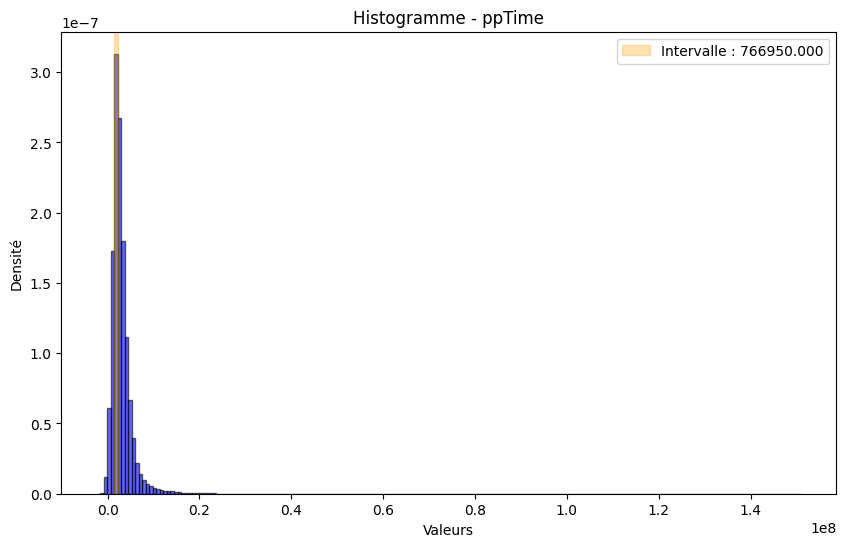

Catégorie : rrTime
  - Intervalle avec la densité maximale : [1442750.000, 2205300.000]
  - Longueur de l'intervalle : 762550.000


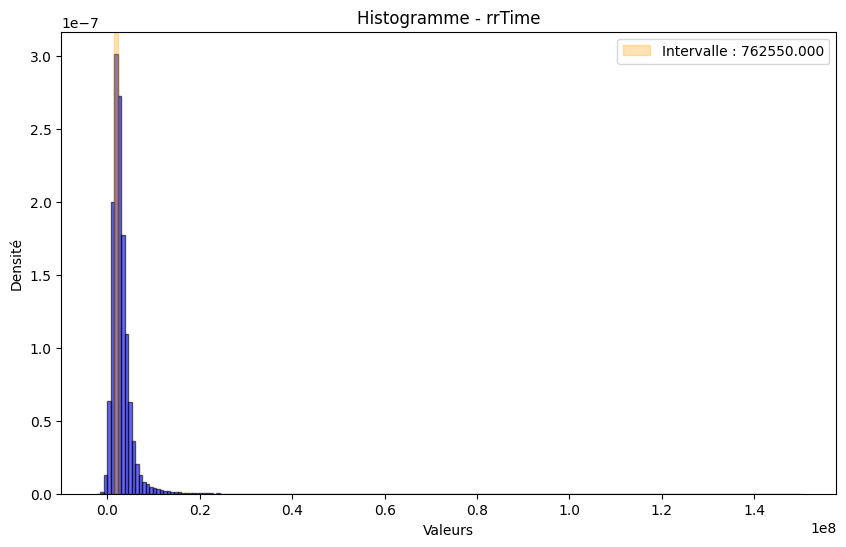

Catégorie : rpTime
  - Intervalle avec la densité maximale : [1297250.000, 2068700.000]
  - Longueur de l'intervalle : 771450.000


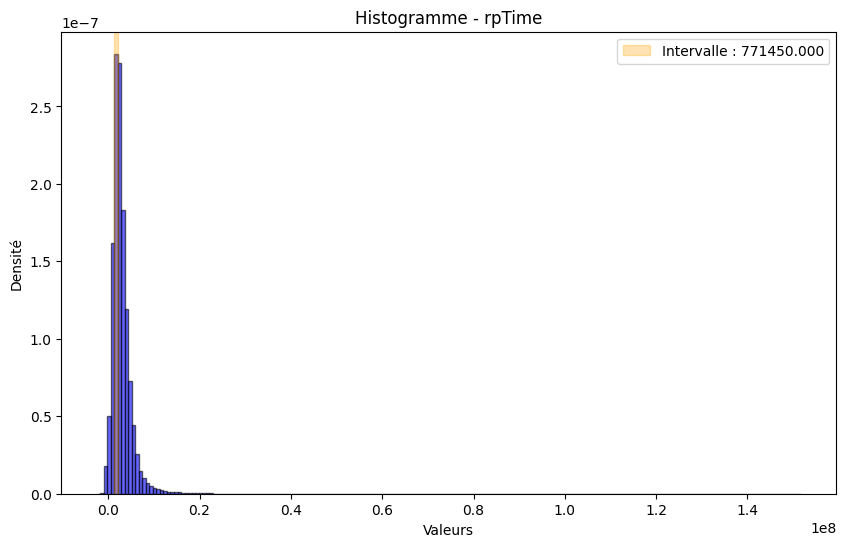

Catégorie : prTime
  - Intervalle avec la densité maximale : [1420400.000, 2183000.000]
  - Longueur de l'intervalle : 762600.000


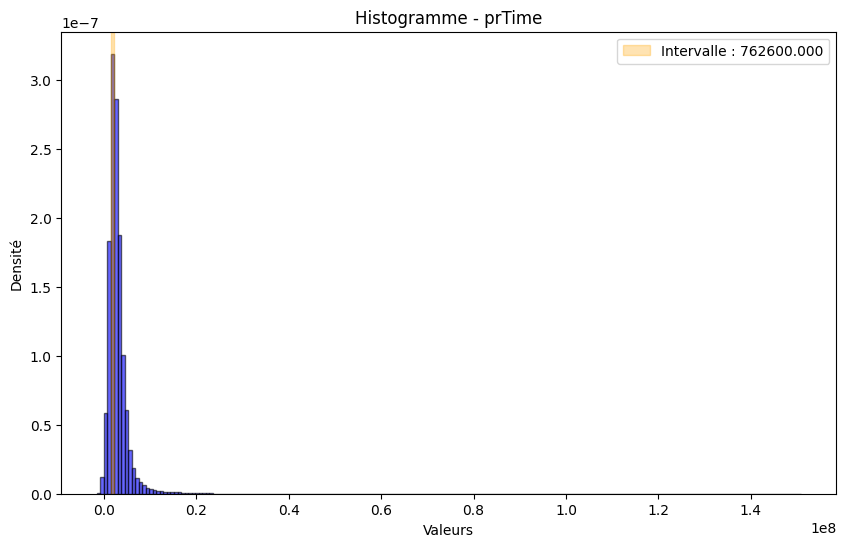

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des fichiers CSV fournis
csv_files = [
    "/content/sample_data/GREYCNISLAB_NEW_P1.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P2.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P3.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P4.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P5.csv"
]

# Ordre des catégories (modulo 4)
categories = ["ppTime", "rrTime", "rpTime", "prTime"]
global_category_data = {category: [] for category in categories}  # Données globales pour chaque catégorie

# Parcourir les fichiers et collecter les données pour chaque catégorie
start_column = 6  # La 6ᵉ colonne (indexée à partir de 0 en Python)
for file in csv_files:
    data = pd.read_csv(file)
    for i, col_name in enumerate(data.columns[start_column:], start=start_column):
        # Identifier la catégorie à l'aide du modulo 4
        category = categories[(i - start_column) % 4]
        # Ajouter les données de la colonne correspondante à la catégorie globale
        global_category_data[category].extend(data[col_name].dropna().tolist())

# Analyse et affichage des résultats pour chaque catégorie
num_bins = 200  # Nombre de bins pour l'histogramme
results = {}

for category, values in global_category_data.items():
    # Convertir les données en un tableau numpy
    values = np.array(values)

    # Créer un histogramme pour calculer la densité
    hist, bin_edges = np.histogram(values, bins=num_bins, density=True)

    # Identifier l'intervalle avec la densité maximale
    max_density_index = np.argmax(hist)
    interval_start = bin_edges[max_density_index]
    interval_end = bin_edges[max_density_index + 1]
    interval_length = interval_end - interval_start

    # Sauvegarder les résultats
    results[category] = {
        "interval_start": interval_start,
        "interval_end": interval_end,
        "interval_length": interval_length
    }

    # Afficher les résultats pour la catégorie
    print(f"Catégorie : {category}")
    print(f"  - Intervalle avec la densité maximale : [{interval_start:.3f}, {interval_end:.3f}]")
    print(f"  - Longueur de l'intervalle : {interval_length:.3f}")

    # Tracer l'histogramme pour toutes les données
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=num_bins, alpha=0.6, color='blue', edgecolor='black', density=True)
    plt.axvspan(interval_start, interval_end, color='orange', alpha=0.3, label=f"Intervalle : {interval_length:.3f}")
    plt.title(f"Histogramme - {category}")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()


In [ ]:
# Résultats des intervalles identifiés pour chaque catégorie (les plus fréquents)
results = {
    "ppTime": {"interval_start": 657800, "interval_end": 3725600, "interval_length": 3067800},
    "rrTime": {"interval_start": 680200, "interval_end": 3730400, "interval_length": 3050200},
    "rpTime": {"interval_start": 525800, "interval_end": 3611600, "interval_length": 3085800},
    "prTime": {"interval_start": 1420400, "interval_end": 4470800, "interval_length": 3050400},
}

# Catégories à utiliser modulo 4
categories = ["ppTime", "rrTime", "rpTime", "prTime"]

# Nombre de subdivisions
fine_subdivisions = 10  # Pour les intervalles les plus fréquents
coarse_subdivisions = 3  # Pour les autres intervalles

# Traiter chaque fichier CSV
for input_file in csv_files:
    print(f"Traitement du fichier : {input_file}")

    # Charger les données
    data = pd.read_csv(input_file)

    # Créer un nouveau DataFrame pour stocker les colonnes transformées
    refined_data = pd.DataFrame()

    # Ajouter les 5 premières colonnes intactes
    refined_data = data.iloc[:, :5].copy()

    # Parcourir les colonnes à partir de la 6ᵉ et traiter par catégorie (modulo 4)
    start_column = 5  # La 6ᵉ colonne (indexée à 5)
    for category in categories:
        # Trouver les colonnes correspondant à cette catégorie
        category_columns = [
            col for i, col in enumerate(data.columns[start_column:], start=start_column)
            if categories[(i - start_column) % 4] == category
        ]

        if not category_columns:
            print(f"Aucune colonne trouvée pour la catégorie {category} dans {input_file}.")
            continue

        # Combiner toutes les données de la catégorie pour définir les intervalles
        category_values = data[category_columns].stack().values

        # Définir les bins (intervalles)
        min_value, max_value = np.min(category_values), np.max(category_values)
        refined_bins = []

        # Diviser les intervalles fréquents en subdivisions fines
        frequent_start = results[category]["interval_start"]
        frequent_end = results[category]["interval_end"]
        refined_bins += list(np.linspace(frequent_start, frequent_end, fine_subdivisions + 1))

        # Diviser les intervalles avant et après en subdivisions grossières
        refined_bins += list(np.linspace(min_value, frequent_start, coarse_subdivisions + 1))[:-1]
        refined_bins += list(np.linspace(frequent_end, max_value, coarse_subdivisions + 1))[1:]

        refined_bins = sorted(set(refined_bins))  # Éviter les doublons

        # Ajouter des colonnes pour chaque sous-intervalle
        for idx in range(len(refined_bins) - 1):
            interval_start = refined_bins[idx]
            interval_end = refined_bins[idx + 1]
            interval_label = f"{category}_[{interval_start:.0f},{interval_end:.0f}]"

            # Calculer les fréquences pour cet intervalle
            interval_counts = np.zeros(len(data))  # Initialiser un tableau de fréquences pour chaque ligne
            for col_name in category_columns:
                col_values = data[col_name].values
                # Compter les occurrences des valeurs dans l'intervalle
                interval_counts += ((col_values >= interval_start) & (col_values < interval_end)).astype(int)

            # Ajouter la colonne au DataFrame final
            refined_data[interval_label] = interval_counts

        # Ajouter une colonne séparatrice pour indiquer le passage à une autre catégorie
        refined_data[f"{category}_END"] = ""  # Indique la fin des colonnes de la catégorie

    # Enregistrer le fichier modifié
    output_file = input_file.replace(".csv", "_refined.csv")
    refined_data.to_csv(output_file, index=False)

    print(f"Fichier modifié enregistré : {output_file}")


Fichier modifié enregistré : /content/sample_data/GREYCNISLAB_NEW_P1_refined.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# PARAMÈTRES CONFIGURABLES
# =====================================
csv_files = [
    "/content/sample_data/GREYCNISLAB_NEW_P1.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P2.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P3.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P4.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P5.csv"
]

categories = ["ppTime", "rrTime", "rpTime", "prTime"]
num_bins_global = 50                # Bins pour l'analyse globale
density_percentile = 90              # Percentile pour seuil de densité
fine_subdivisions = 10               # Subdivisions pour zones denses
coarse_subdivisions = 3              # Subdivisions pour zones rares

# =====================================
# PHASE 1 - ANALYSE GLOBALE
# =====================================
# Collecte des données pour chaque catégorie
global_data = {cat: [] for cat in categories}

for file in csv_files:
    df = pd.read_csv(file)
    for i, col in enumerate(df.columns[5:]):  # Colonnes à partir de l'index 5
        cat = categories[i % 4]
        global_data[cat].extend(df[col].dropna().values)

# Calcul des intervalles de haute densité
global_intervals = {}

for cat, values in global_data.items():
    if not values:
        continue

    # Calcul de l'histogramme
    hist, bins = np.histogram(values, bins=num_bins_global, density=True)

    # Détermination du seuil de densité
    threshold = np.percentile(hist, density_percentile)

    # Identification des intervalles denses
    dense_intervals = []
    for i in range(len(hist)):
        if hist[i] > threshold:
            dense_intervals.append((bins[i], bins[i+1]))

    global_intervals[cat] = dense_intervals

# =====================================
# PHASE 2 - TRAITEMENT PAR FICHIER
# =====================================
for input_file in csv_files:
    print(f"\nTraitement de {input_file}...")

    # Chargement des données
    df = pd.read_csv(input_file)
    refined_df = df.iloc[:, :5].copy()  # Conserver les 5 premières colonnes

    for cat in categories:
        # Récupération des colonnes de la catégorie
        cat_cols = [
            col for i, col in enumerate(df.columns[5:])
            if categories[i % 4] == cat
        ]

        if not cat_cols:
            continue

        # Extraction des valeurs
        try:
            stacked_values = df[cat_cols].stack().dropna()
            if stacked_values.empty:
                continue
        except:
            continue

        min_val = stacked_values.min()
        max_val = stacked_values.max()

        # Adaptation des intervalles globaux
        adapted_intervals = []
        for interval in global_intervals.get(cat, []):
            start = max(interval[0], min_val)
            end = min(interval[1], max_val)
            if start < end:
                adapted_intervals.append((start, end))

        # Construction des bins
        bins = []

        # 1. Intervalles denses (subdivisions fines)
        for start, end in sorted(adapted_intervals):
            bins.extend(np.linspace(start, end, fine_subdivisions + 1))

        # 2. Zones restantes (subdivisions grossières)
        current = min_val
        remaining = []

        for start, end in sorted(adapted_intervals):
            if current < start:
                remaining.append((current, start))
            current = max(current, end)

        if current < max_val:
            remaining.append((current, max_val))

        for start, end in remaining:
            bins.extend(np.linspace(start, end, coarse_subdivisions + 1)[:-1])

        # Nettoyage des bins
        bins = sorted(list(set(bins)))
        bins = [b for b in bins if min_val <= b <= max_val]

        # Vérification finale des bins
        if len(bins) < 2:
            print(f"Pas assez de bins pour {cat}")
            continue

        # Comptage intelligent avec bornes inclusives
        for i in range(len(bins)-1):
            lower = bins[i]
            upper = bins[i+1]
            col_name = f"{cat}_[{lower:.1f}-{upper:.1f}]"

            counts = np.zeros(len(df))

            for col in cat_cols:
                vals = df[col].values
                if i == len(bins)-2:  # Dernier intervalle
                    mask = (vals >= lower) & (vals <= upper)
                else:
                    mask = (vals >= lower) & (vals < upper)
                counts += mask.astype(int)

            refined_df[col_name] = counts

    # Sauvegarde
    output_file = input_file.replace(".csv", "_refined.csv")
    refined_df.to_csv(output_file, index=False)
    print(f"Fichier généré : {output_file}")

# =====================================
# PHASE 3 - COMBINAISON DES RÉSULTATS
# =====================================
refined_files = [f.replace(".csv", "_refined.csv") for f in csv_files]
output_xlsx = "/content/sample_data/combined_results.xlsx"

with pd.ExcelWriter(output_xlsx, engine="openpyxl") as writer:
    for file in refined_files:
        try:
            df = pd.read_csv(file)
            sheet_name = file.split("/")[-1].replace("_refined.csv", "")[:31]
            df.to_excel(writer, sheet_name=sheet_name, index=False)
        except Exception as e:
            print(f"Erreur avec {file} : {str(e)}")

print(f"\nTraitement terminé ! Fichier combiné : {output_xlsx}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/GREYCNISLAB_NEW_P1.csv'

In [ ]:
import pandas as pd

# Liste des fichiers raffinés
refined_files = [
    "/content/sample_data/GREYCNISLAB_NEW_P1_refined.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P2_refined.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P3_refined.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P4_refined.csv",
    "/content/sample_data/GREYCNISLAB_NEW_P5_refined.csv"
]

# Fichier de sortie Excel
output_file = "/content/sample_data/combined_refined_data.xlsx"  # Utiliser une extension .xlsx

# Modifier l'engine pour utiliser openpyxl
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for file in refined_files:
        print(f"Chargement du fichier : {file}")
        try:
            # Charger le fichier raffiné
            df = pd.read_csv(file)
            # Nom de la feuille basé sur le nom du fichier
            sheet_name = file.split("/")[-1].replace("_refined.csv", "")
            # Écrire le DataFrame dans une feuille distincte
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Fichier ajouté à la feuille : {sheet_name}")
        except Exception as e:
            print(f"Erreur lors du chargement du fichier {file} : {e}")

print(f"Tous les fichiers ont été combinés dans : {output_file}")

Chargement du fichier : /content/sample_data/GREYCNISLAB_NEW_P1_refined.csv
Fichier ajouté à la feuille : GREYCNISLAB_NEW_P1
Chargement du fichier : /content/sample_data/GREYCNISLAB_NEW_P2_refined.csv
Fichier ajouté à la feuille : GREYCNISLAB_NEW_P2
Chargement du fichier : /content/sample_data/GREYCNISLAB_NEW_P3_refined.csv
Fichier ajouté à la feuille : GREYCNISLAB_NEW_P3
Chargement du fichier : /content/sample_data/GREYCNISLAB_NEW_P4_refined.csv
Fichier ajouté à la feuille : GREYCNISLAB_NEW_P4
Chargement du fichier : /content/sample_data/GREYCNISLAB_NEW_P5_refined.csv
Fichier ajouté à la feuille : GREYCNISLAB_NEW_P5
Tous les fichiers ont été combinés dans : /content/sample_data/combined_refined_data.xlsx
